In [1]:
### Start Spark Session
sc

VBox()

Starting Spark application


ID,YARN Application ID,Kind,State,Spark UI,Driver log,Current session?
1,application_1613386717725_0002,pyspark,idle,Link,Link,✔


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

SparkSession available as 'spark'.


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

<SparkContext master=yarn appName=livy-session-1>

In [2]:
from pyspark.sql.functions import *

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [3]:
###Import mobility and case data into Spark
mobility_data = "s3://csc8002/data.csv"
cases_data = "s3://csc8002/covid_cases.csv"

mobility = spark.read.csv(mobility_data,
                                 header=True,
                                 inferSchema=True)

cases = spark.read.csv(cases_data,
                                 header=True,
                                 inferSchema=True)
                                

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [4]:
mobility.show(n=2, truncate=False, vertical=True)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

-RECORD 0------------------------------------------------------------------
 country_region_code                                | AE                   
 country_region                                     | United Arab Emirates 
 sub_region_1                                       | null                 
 sub_region_2                                       | null                 
 metro_area                                         | null                 
 iso_3166_2_code                                    | null                 
 census_fips_code                                   | null                 
 date                                               | 2020-02-15 00:00:00  
 retail_and_recreation_percent_change_from_baseline | 0                    
 grocery_and_pharmacy_percent_change_from_baseline  | 4                    
 parks_percent_change_from_baseline                 | 5                    
 transit_stations_percent_change_from_baseline      | 0                    
 workplaces_

In [5]:
cases.show(n=2, truncate=False, vertical=True)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

-RECORD 0----------------------------------------------------
 iso_code                              | AFG                 
 continent                             | Asia                
 location                              | Afghanistan         
 date                                  | 2020-02-24 00:00:00 
 total_cases                           | 1.0                 
 new_cases                             | 1.0                 
 new_cases_smoothed                    | null                
 total_deaths                          | null                
 new_deaths                            | null                
 new_deaths_smoothed                   | null                
 total_cases_per_million               | 0.026               
 new_cases_per_million                 | 0.026               
 new_cases_smoothed_per_million        | null                
 total_deaths_per_million              | null                
 new_deaths_per_million                | null                
 new_dea

In [6]:
### AUSTRALIAN MOBILITY DATA PREPARATION
### Select Australian Mobility Data where sub region 1 and 2 are null - data for Australia as a whole
aus_mobility = mobility.select("*").where("country_region == 'Australia'")
aus_mobility = aus_mobility.filter(aus_mobility.sub_region_1.isNull() & aus_mobility.sub_region_2.isNull())
aus_mobility.show(n=2, truncate=False, vertical=True)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

-RECORD 0-----------------------------------------------------------------
 country_region_code                                | AU                  
 country_region                                     | Australia           
 sub_region_1                                       | null                
 sub_region_2                                       | null                
 metro_area                                         | null                
 iso_3166_2_code                                    | null                
 census_fips_code                                   | null                
 date                                               | 2020-02-15 00:00:00 
 retail_and_recreation_percent_change_from_baseline | 4                   
 grocery_and_pharmacy_percent_change_from_baseline  | 3                   
 parks_percent_change_from_baseline                 | -2                  
 transit_stations_percent_change_from_baseline      | 3                   
 workplaces_percent_chang

In [7]:
#### Remove Columns that are not required for analysis
aus_mobility = aus_mobility.drop('country_region_code', 'sub_region_1', 'sub_region_2','metro_area','iso_3166_2_code', 'census_fips_code')
aus_mobility.show(n=2, truncate=False, vertical=True)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

-RECORD 0-----------------------------------------------------------------
 country_region                                     | Australia           
 date                                               | 2020-02-15 00:00:00 
 retail_and_recreation_percent_change_from_baseline | 4                   
 grocery_and_pharmacy_percent_change_from_baseline  | 3                   
 parks_percent_change_from_baseline                 | -2                  
 transit_stations_percent_change_from_baseline      | 3                   
 workplaces_percent_change_from_baseline            | 3                   
 residential_percent_change_from_baseline           | 0                   
-RECORD 1-----------------------------------------------------------------
 country_region                                     | Australia           
 date                                               | 2020-02-16 00:00:00 
 retail_and_recreation_percent_change_from_baseline | 3                   
 grocery_and_pharmacy_per

In [8]:
### Convert date to date/time object
from pyspark.sql.functions import to_timestamp,to_date
from pyspark.sql.functions import col, column
dateFormat = "yyyy-MM-dd"
aus_mobility = aus_mobility.withColumn("date", to_timestamp(col("date"), dateFormat))
aus_mobility.show(n=2, truncate=False, vertical=True)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

-RECORD 0-----------------------------------------------------------------
 country_region                                     | Australia           
 date                                               | 2020-02-15 00:00:00 
 retail_and_recreation_percent_change_from_baseline | 4                   
 grocery_and_pharmacy_percent_change_from_baseline  | 3                   
 parks_percent_change_from_baseline                 | -2                  
 transit_stations_percent_change_from_baseline      | 3                   
 workplaces_percent_change_from_baseline            | 3                   
 residential_percent_change_from_baseline           | 0                   
-RECORD 1-----------------------------------------------------------------
 country_region                                     | Australia           
 date                                               | 2020-02-16 00:00:00 
 retail_and_recreation_percent_change_from_baseline | 3                   
 grocery_and_pharmacy_per

In [9]:
### Create data frames for each mobility catergory
aus_rec = aus_mobility.selectExpr("date","retail_and_recreation_percent_change_from_baseline as aus_retail")
aus_groc = aus_mobility.selectExpr("date","grocery_and_pharmacy_percent_change_from_baseline as aus_grocery")
aus_transit = aus_mobility.selectExpr("date","transit_stations_percent_change_from_baseline as aus_transit")
aus_parks = aus_mobility.selectExpr("date","parks_percent_change_from_baseline as aus_parks")
aus_work = aus_mobility.selectExpr("date","workplaces_percent_change_from_baseline as aus_work")
aus_home = aus_mobility.selectExpr("date","residential_percent_change_from_baseline as aus_home")

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [10]:
###SWEDISH MOBILITY DATA PREPARATION
### Select Swedish Mobility Data where sub region 1 and 2 are null - data for Sweden as a whole
sweden_mobility = mobility.select("*").where("country_region == 'Sweden'")
sweden_mobility = sweden_mobility.filter(sweden_mobility.sub_region_1.isNull() & sweden_mobility.sub_region_2.isNull())
sweden_mobility.show(n=2, truncate=False, vertical=True)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

-RECORD 0-----------------------------------------------------------------
 country_region_code                                | SE                  
 country_region                                     | Sweden              
 sub_region_1                                       | null                
 sub_region_2                                       | null                
 metro_area                                         | null                
 iso_3166_2_code                                    | null                
 census_fips_code                                   | null                
 date                                               | 2020-02-15 00:00:00 
 retail_and_recreation_percent_change_from_baseline | 2                   
 grocery_and_pharmacy_percent_change_from_baseline  | 0                   
 parks_percent_change_from_baseline                 | 3                   
 transit_stations_percent_change_from_baseline      | 4                   
 workplaces_percent_chang

In [11]:
#### Remove Columns that are not required for analysis
sweden_mobility = sweden_mobility.drop('country_region_code', 'sub_region_1', 'sub_region_2','metro_area','iso_3166_2_code', 'census_fips_code')
sweden_mobility.show(n=2, truncate=False, vertical=True)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

-RECORD 0-----------------------------------------------------------------
 country_region                                     | Sweden              
 date                                               | 2020-02-15 00:00:00 
 retail_and_recreation_percent_change_from_baseline | 2                   
 grocery_and_pharmacy_percent_change_from_baseline  | 0                   
 parks_percent_change_from_baseline                 | 3                   
 transit_stations_percent_change_from_baseline      | 4                   
 workplaces_percent_change_from_baseline            | -2                  
 residential_percent_change_from_baseline           | 0                   
-RECORD 1-----------------------------------------------------------------
 country_region                                     | Sweden              
 date                                               | 2020-02-16 00:00:00 
 retail_and_recreation_percent_change_from_baseline | -10                 
 grocery_and_pharmacy_per

In [12]:
### Convert date to date/time object
dateFormat = "yyyy-MM-dd"
sweden_mobility = sweden_mobility.withColumn("date", to_timestamp(col("date"), dateFormat))
sweden_mobility.show(n=2, truncate=False, vertical=True)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

-RECORD 0-----------------------------------------------------------------
 country_region                                     | Sweden              
 date                                               | 2020-02-15 00:00:00 
 retail_and_recreation_percent_change_from_baseline | 2                   
 grocery_and_pharmacy_percent_change_from_baseline  | 0                   
 parks_percent_change_from_baseline                 | 3                   
 transit_stations_percent_change_from_baseline      | 4                   
 workplaces_percent_change_from_baseline            | -2                  
 residential_percent_change_from_baseline           | 0                   
-RECORD 1-----------------------------------------------------------------
 country_region                                     | Sweden              
 date                                               | 2020-02-16 00:00:00 
 retail_and_recreation_percent_change_from_baseline | -10                 
 grocery_and_pharmacy_per

In [13]:
### Create data frames for each mobility catergory
sweden_rec = sweden_mobility.selectExpr("date","retail_and_recreation_percent_change_from_baseline as sweden_retail")
sweden_groc = sweden_mobility.selectExpr("date","grocery_and_pharmacy_percent_change_from_baseline as sweden_grocery")
sweden_transit = sweden_mobility.selectExpr("date","transit_stations_percent_change_from_baseline as sweden_transit")
sweden_parks = sweden_mobility.selectExpr("date","parks_percent_change_from_baseline as sweden_parks")
sweden_work = sweden_mobility.selectExpr("date","workplaces_percent_change_from_baseline as sweden_work")
sweden_home = sweden_mobility.selectExpr("date","residential_percent_change_from_baseline as sweden_home")

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [14]:
### AUSTRALIAN CASE DATA PREPARATION
### Select Australian Case Data
aus_cases = cases.select("*").where("location == 'Australia'")

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [15]:
#### Select Columns that are required for analysis
aus_cases = aus_cases.select('location', 'date', 'total_cases','new_cases','new_cases_smoothed','total_cases_per_million',
                             'new_cases_per_million', 'new_cases_smoothed_per_million','population')
aus_cases.show(n=2, truncate=False, vertical=True)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

-RECORD 0---------------------------------------------
 location                       | Australia           
 date                           | 2020-01-26 00:00:00 
 total_cases                    | 4.0                 
 new_cases                      | 4.0                 
 new_cases_smoothed             | null                
 total_cases_per_million        | 0.157               
 new_cases_per_million          | 0.157               
 new_cases_smoothed_per_million | null                
 population                     | 2.5499881E7         
-RECORD 1---------------------------------------------
 location                       | Australia           
 date                           | 2020-01-27 00:00:00 
 total_cases                    | 5.0                 
 new_cases                      | 1.0                 
 new_cases_smoothed             | null                
 total_cases_per_million        | 0.196               
 new_cases_per_million          | 0.039               
 new_cases

In [16]:
### Convert date to date/time object
aus_cases = aus_cases.withColumn("date", to_timestamp(col("date"), dateFormat))
aus_cases.show(n=2, truncate=False, vertical=True)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

-RECORD 0---------------------------------------------
 location                       | Australia           
 date                           | 2020-01-26 00:00:00 
 total_cases                    | 4.0                 
 new_cases                      | 4.0                 
 new_cases_smoothed             | null                
 total_cases_per_million        | 0.157               
 new_cases_per_million          | 0.157               
 new_cases_smoothed_per_million | null                
 population                     | 2.5499881E7         
-RECORD 1---------------------------------------------
 location                       | Australia           
 date                           | 2020-01-27 00:00:00 
 total_cases                    | 5.0                 
 new_cases                      | 1.0                 
 new_cases_smoothed             | null                
 total_cases_per_million        | 0.196               
 new_cases_per_million          | 0.039               
 new_cases

In [17]:
### Select data for time period 15/2/2020-1/12/2020
dates = ("2020-02-15","2020-12-01")
aus_cases = aus_cases.where(col('date').between(*dates))
aus_cases.show(n=2, truncate=False, vertical=True)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

-RECORD 0---------------------------------------------
 location                       | Australia           
 date                           | 2020-02-15 00:00:00 
 total_cases                    | 15.0                
 new_cases                      | 0.0                 
 new_cases_smoothed             | 0.0                 
 total_cases_per_million        | 0.588               
 new_cases_per_million          | 0.0                 
 new_cases_smoothed_per_million | 0.0                 
 population                     | 2.5499881E7         
-RECORD 1---------------------------------------------
 location                       | Australia           
 date                           | 2020-02-16 00:00:00 
 total_cases                    | 15.0                
 new_cases                      | 0.0                 
 new_cases_smoothed             | 0.0                 
 total_cases_per_million        | 0.588               
 new_cases_per_million          | 0.0                 
 new_cases

In [18]:
### SWEDISH CASE DATA PREPARATION
### Select Swedish Case Data
sweden_cases = cases.select("*").where("location == 'Sweden'")
sweden_cases.show(n=2, truncate=False, vertical=True)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

-RECORD 0----------------------------------------------------
 iso_code                              | SWE                 
 continent                             | Europe              
 location                              | Sweden              
 date                                  | 2020-02-01 00:00:00 
 total_cases                           | 1.0                 
 new_cases                             | 1.0                 
 new_cases_smoothed                    | null                
 total_deaths                          | null                
 new_deaths                            | null                
 new_deaths_smoothed                   | null                
 total_cases_per_million               | 0.099               
 new_cases_per_million                 | 0.099               
 new_cases_smoothed_per_million        | null                
 total_deaths_per_million              | null                
 new_deaths_per_million                | null                
 new_dea

In [19]:
#### Select Columns that are required for analysis
sweden_cases = sweden_cases.select('location', 'date', 'total_cases','new_cases','new_cases_smoothed','total_cases_per_million',
                             'new_cases_per_million', 'new_cases_smoothed_per_million','population')
sweden_cases.show(n=2, truncate=False, vertical=True)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

-RECORD 0---------------------------------------------
 location                       | Sweden              
 date                           | 2020-02-01 00:00:00 
 total_cases                    | 1.0                 
 new_cases                      | 1.0                 
 new_cases_smoothed             | null                
 total_cases_per_million        | 0.099               
 new_cases_per_million          | 0.099               
 new_cases_smoothed_per_million | null                
 population                     | 1.009927E7          
-RECORD 1---------------------------------------------
 location                       | Sweden              
 date                           | 2020-02-02 00:00:00 
 total_cases                    | 1.0                 
 new_cases                      | 0.0                 
 new_cases_smoothed             | null                
 total_cases_per_million        | 0.099               
 new_cases_per_million          | 0.0                 
 new_cases

In [20]:
### Convert date to date/time object
sweden_cases = sweden_cases.withColumn("date", to_timestamp(col("date"), dateFormat))
sweden_cases.show(n=2, truncate=False, vertical=True)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

-RECORD 0---------------------------------------------
 location                       | Sweden              
 date                           | 2020-02-01 00:00:00 
 total_cases                    | 1.0                 
 new_cases                      | 1.0                 
 new_cases_smoothed             | null                
 total_cases_per_million        | 0.099               
 new_cases_per_million          | 0.099               
 new_cases_smoothed_per_million | null                
 population                     | 1.009927E7          
-RECORD 1---------------------------------------------
 location                       | Sweden              
 date                           | 2020-02-02 00:00:00 
 total_cases                    | 1.0                 
 new_cases                      | 0.0                 
 new_cases_smoothed             | null                
 total_cases_per_million        | 0.099               
 new_cases_per_million          | 0.0                 
 new_cases

In [21]:
### Select data for time period 15/2/2020-1/12/2020
dates = ("2020-02-15","2020-12-01")
sweden_cases = sweden_cases.where(col('date').between(*dates))
sweden_cases.show(n=2, truncate=False, vertical=True)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

-RECORD 0---------------------------------------------
 location                       | Sweden              
 date                           | 2020-02-15 00:00:00 
 total_cases                    | 1.0                 
 new_cases                      | 0.0                 
 new_cases_smoothed             | 0.0                 
 total_cases_per_million        | 0.099               
 new_cases_per_million          | 0.0                 
 new_cases_smoothed_per_million | 0.0                 
 population                     | 1.009927E7          
-RECORD 1---------------------------------------------
 location                       | Sweden              
 date                           | 2020-02-16 00:00:00 
 total_cases                    | 1.0                 
 new_cases                      | 0.0                 
 new_cases_smoothed             | 0.0                 
 total_cases_per_million        | 0.099               
 new_cases_per_million          | 0.0                 
 new_cases

In [ ]:
### DESCRIPTIVE STATISTICS - MOBILITY DATA

In [22]:
aus_mobility.describe().show(truncate=False, vertical=True)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

-RECORD 0-----------------------------------------------------------------
 summary                                            | count               
 country_region                                     | 291                 
 retail_and_recreation_percent_change_from_baseline | 291                 
 grocery_and_pharmacy_percent_change_from_baseline  | 291                 
 parks_percent_change_from_baseline                 | 291                 
 transit_stations_percent_change_from_baseline      | 291                 
 workplaces_percent_change_from_baseline            | 291                 
 residential_percent_change_from_baseline           | 291                 
-RECORD 1-----------------------------------------------------------------
 summary                                            | mean                
 country_region                                     | null                
 retail_and_recreation_percent_change_from_baseline | -18.5979381443299   
 grocery_and_pharmacy_per

In [23]:
sweden_mobility.describe().show(truncate=False, vertical=True)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

-RECORD 0-----------------------------------------------------------------
 summary                                            | count               
 country_region                                     | 291                 
 retail_and_recreation_percent_change_from_baseline | 291                 
 grocery_and_pharmacy_percent_change_from_baseline  | 291                 
 parks_percent_change_from_baseline                 | 291                 
 transit_stations_percent_change_from_baseline      | 291                 
 workplaces_percent_change_from_baseline            | 291                 
 residential_percent_change_from_baseline           | 291                 
-RECORD 1-----------------------------------------------------------------
 summary                                            | mean                
 country_region                                     | null                
 retail_and_recreation_percent_change_from_baseline | -8.532646048109966  
 grocery_and_pharmacy_per

In [ ]:
### DESCRIPTIVE STATISTICS - CASE DATA

In [24]:
aus_cases.describe().show(truncate=False, vertical=True)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

-RECORD 0--------------------------------------------
 summary                        | count              
 location                       | 290                
 total_cases                    | 290                
 new_cases                      | 290                
 new_cases_smoothed             | 290                
 total_cases_per_million        | 290                
 new_cases_per_million          | 290                
 new_cases_smoothed_per_million | 290                
 population                     | 290                
-RECORD 1--------------------------------------------
 summary                        | mean               
 location                       | null               
 total_cases                    | 14548.082758620689 
 new_cases                      | 96.19655172413793  
 new_cases_smoothed             | 96.09751034482758  
 total_cases_per_million        | 570.515696551724   
 new_cases_per_million          | 3.7724275862068963 
 new_cases_smoothed_per_mill

In [25]:
sweden_cases.describe().show(truncate=False, vertical=True)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

-RECORD 0--------------------------------------------
 summary                        | count              
 location                       | 290                
 total_cases                    | 290                
 new_cases                      | 290                
 new_cases_smoothed             | 290                
 total_cases_per_million        | 290                
 new_cases_per_million          | 290                
 new_cases_smoothed_per_million | 290                
 population                     | 290                
-RECORD 1--------------------------------------------
 summary                        | mean               
 location                       | null               
 total_cases                    | 66232.74827586208  
 new_cases                      | 838.3724137931034  
 new_cases_smoothed             | 820.1665206896556  
 total_cases_per_million        | 6558.171831034483  
 new_cases_per_million          | 83.01316551724136  
 new_cases_smoothed_per_mill

In [ ]:
### VISUALISATIONS

In [26]:
sc.install_pypi_package("pandas==0.25.1")
sc.install_pypi_package("matplotlib", "https://pypi.org/simple")

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [28]:
### Bring data into Pandas
aus_cases_pd = aus_cases.toPandas()
sweden_cases_pd = sweden_cases.toPandas()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [29]:
###Bring Australia mobility data into Pandas
aus_rec_pd = aus_rec.toPandas()
aus_groc_pd = aus_groc.toPandas()
aus_home_pd = aus_home.toPandas()
aus_parks_pd = aus_parks.toPandas()
aus_transit_pd = aus_transit.toPandas()
aus_work_pd = aus_work.toPandas()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [30]:
### Bring Sweden mobility data into Pandas
sweden_rec_pd = sweden_rec.toPandas()
sweden_groc_pd = sweden_groc.toPandas()
sweden_home_pd = sweden_home.toPandas()
sweden_parks_pd = sweden_parks.toPandas()
sweden_transit_pd = sweden_transit.toPandas()
sweden_work_pd = sweden_work.toPandas()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [31]:
### Create log10 values for new cases, convert infinity values to null and remove - Sweden
sweden_cases_pd['sweden_new_cases_log10'] = np.log10(sweden_cases_pd['new_cases'])
pd.set_option('mode.use_inf_as_na', True)
sweden_cases_pd = sweden_cases_pd[sweden_cases_pd['sweden_new_cases_log10'].notna()]

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

/tmp/1613387498858-0/lib/python3.7/site-packages/pandas/core/series.py:853: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)

In [32]:
### Create log10 values for new cases, convert infinity values to null and remove - Australia
aus_cases_pd['aus_new_cases_log10'] = np.log10(aus_cases_pd['new_cases'])
aus_cases_pd = aus_cases_pd[aus_cases_pd['aus_new_cases_log10'].notna()]

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

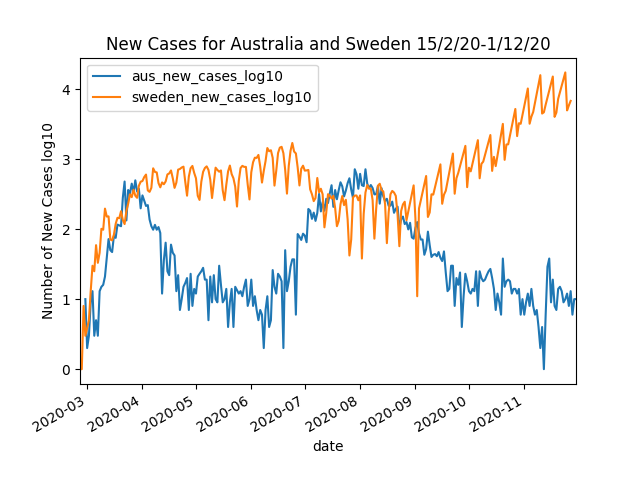

In [33]:
###Logarithmic plot of Australian and Swedish case data
ax = aus_cases_pd.plot("date", "aus_new_cases_log10")
sweden_cases_pd.plot("date", "sweden_new_cases_log10", ax = ax)
plt.ylabel('Number of New Cases log10')
plt.title('New Cases for Australia and Sweden 15/2/20-1/12/20')
%matplot plt

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

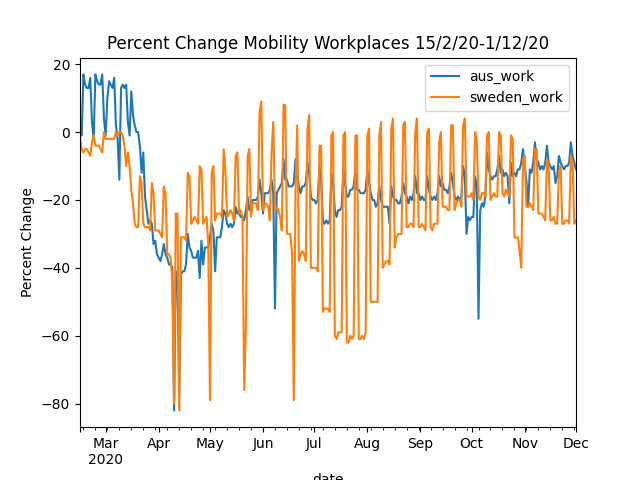

In [34]:
###Mobility plot workplaces
ax = aus_work_pd.plot("date", "aus_work")
sweden_work_pd.plot("date", "sweden_work", ax = ax)
plt.ylabel('Percent Change')
plt.title('Percent Change Mobility Workplaces 15/2/20-1/12/20')
%matplot plt

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

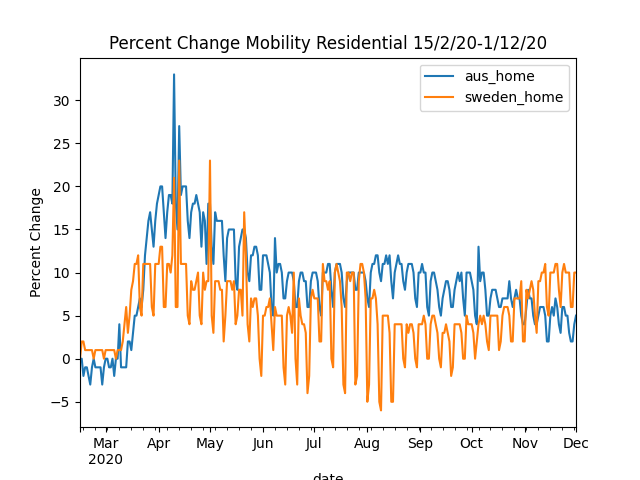

In [35]:
###Mobility plot retail and recreation
ax = aus_home_pd.plot("date", "aus_home")
sweden_home_pd.plot("date", "sweden_home", ax = ax)
plt.ylabel('Percent Change')
plt.title('Percent Change Mobility Residential 15/2/20-1/12/20')
%matplot plt

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

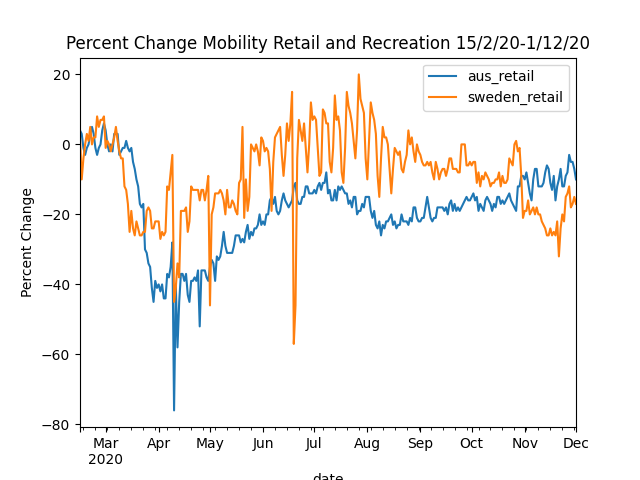

In [36]:
###Mobility plot retail and recreation
ax = aus_rec_pd.plot("date", "aus_retail")
sweden_rec_pd.plot("date", "sweden_retail", ax = ax)
plt.ylabel('Percent Change')
plt.title('Percent Change Mobility Retail and Recreation 15/2/20-1/12/20')
%matplot plt

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

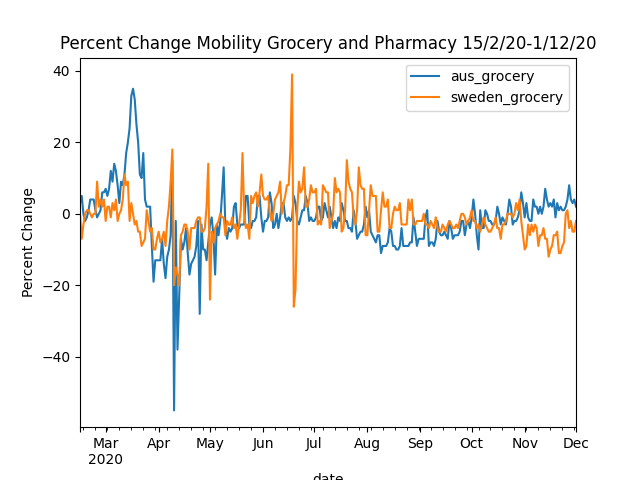

In [37]:
###Mobility plot grocery and pharmacy
ax = aus_groc_pd.plot("date", "aus_grocery")
sweden_groc_pd.plot("date", "sweden_grocery", ax = ax)
plt.ylabel('Percent Change')
plt.title('Percent Change Mobility Grocery and Pharmacy 15/2/20-1/12/20')
%matplot plt

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

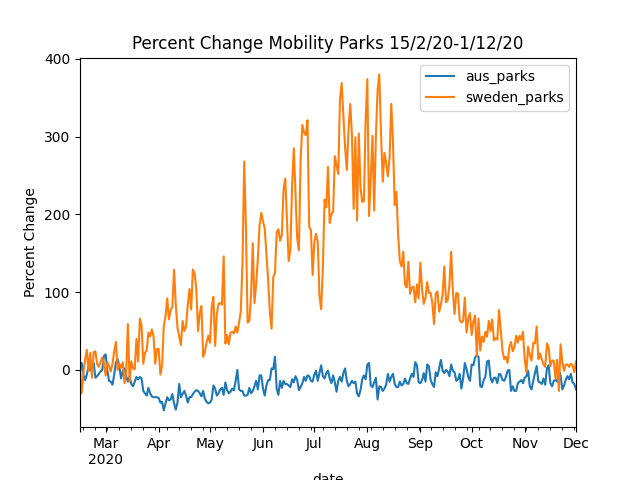

In [38]:
###Mobility plot parks
ax = aus_parks_pd.plot("date", "aus_parks")
sweden_parks_pd.plot("date", "sweden_parks", ax = ax)
plt.ylabel('Percent Change')
plt.title('Percent Change Mobility Parks 15/2/20-1/12/20')
%matplot plt

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

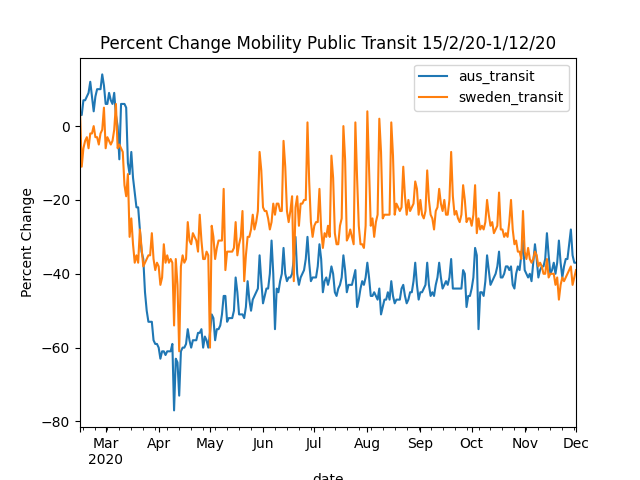

In [39]:
###Mobility plot public transit
ax = aus_transit_pd.plot("date", "aus_transit")
sweden_transit_pd.plot("date", "sweden_transit", ax = ax)
plt.ylabel('Percent Change')
plt.title('Percent Change Mobility Public Transit 15/2/20-1/12/20')
%matplot plt